In [19]:
import torch
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

In [2]:
### Assumption Check, some helpful functions
def combine_weight(model_state):
    """
    For a network, multiply all its weight: W_L W_{L-1} ... W_1
    """
    w = model_state['fc.weight']
    all_weights = []
    for name, para in model_state.items():
        if "weight" in name and "fc" not in name:
            all_weights.append(para.data)
            
    all_weights.reverse()
    for w_l in all_weights:
        w = w @ w_l

    return w

# First Assumption
def check_diff_2(comb_w, train_set_data, train_set_target):
    """
    when data is not orthogonal
    """
    X = train_set_data
    pinv = torch.linalg.pinv(X @ X.T)
    result = (X.T @ pinv @ train_set_target).T
    return torch.linalg.norm(comb_w-result), torch.linalg.norm(comb_w), torch.linalg.norm(result)

# Second Assumption
def check_balance_2(model_state, normalize=False):
    """
    calculate norm(W_iW_i^T - W_{i+1}^T W_{i+1}, 'fro')
    """
    all_weights = []
    for name, para in model_state.items():
        # if "layers" in name and "weight" in name:
        if "weight" in name and len(para.shape) == 2:
            all_weights.append(para.data.cpu())
    
    norm_diffs = []
    for i in range(len(all_weights)-1):
        W_cur, W_next = all_weights[i], all_weights[i+1]
        diff = W_cur @ W_cur.T - W_next.T @ W_next
        if not normalize:
            norm_diffs.append(torch.linalg.norm(diff).item())
        else:
            normalization = torch.linalg.norm(W_cur)
            norm_diffs.append(torch.linalg.norm(diff).item()/normalization)
    
    print(norm_diffs)
    return norm_diffs

# Third Assumption
def calculate_low_effective_rank(delta, num_layers, num_classes):
    """
    Calculate the low effective rank by (512*delta*sqrt{K}) ^ {-1 / (2(L-1))}
    """
    L = num_layers + 1
    K = num_classes
    
    eps = (512 * delta * np.sqrt(K)) ** (-1 / (2 * (L-1)))
    eps = np.minimum(eps, 1)
    
    return eps

def check_singular_value(model_state, num_classes, data_dim):
    K = num_classes
    d = data_dim
    
    all_weights = []
    for name, para in model_state.items():
        if "weight" in name and len(para.shape) == 2:
            all_weights.append(para.data.cpu())
    
    all_sing = []
    for i in range(len(all_weights)-1):
        s = torch.linalg.svdvals(all_weights[i])
        s = s[K:d-K]
        all_sing.extend(s)
    all_sing = torch.tensor(all_sing)
    return torch.min(all_sing), torch.max(all_sing)

### Assumption 2.1

In [3]:
residue = []
w = 400
for d in [1,2,3,4]:#,5
    residue_cur = []
    for seed in range(1,11):
        ckpt = torch.load(f"saved_linear/w{w}_d{d}_init_orthogonal_eps0.1_seed{seed}_assump1/model_last.pth",map_location="cpu")
        w_l1 = combine_weight(ckpt['state_dict'])
        result = check_diff_2(w_l1, ckpt['data'], ckpt['target'])
        residue_cur.append(result[0].item())
    residue.append(residue_cur)

In [4]:
import pickle
to_save = {
            "results": residue
            }
    
with open("depth.pkl", 'wb') as f: 
    pickle.dump(to_save, f)


In [5]:
residue = []
d = 4
for w in [200,300,400,500,600,700]:
    residue_cur = []
    for seed in range(1,11):
        ckpt = torch.load(f"saved_linear/w{w}_d{d}_init_orthogonal_eps0.1_seed{seed}_assump1/model_last.pth",map_location="cpu")
        w_l1 = combine_weight(ckpt['state_dict'])
        result = check_diff_2(w_l1, ckpt['data'], ckpt['target'])
        residue_cur.append(result[0].item())
    residue.append(residue_cur)

In [6]:
import pickle
to_save = {
            "results": residue
            }
    
with open("width.pkl", 'wb') as f: 
    pickle.dump(to_save, f)


### Assumption 2.2

In [ ]:
all_diffs_save = []
w = 400
for d in [1,2,3,4]:#,5
    cur_diffs = []
    for seed in range(1,11):
        ckpt = torch.load(f"saved_linear/w{w}_d{d}_init_orthogonal_eps0.1_seed{seed}_assump1/model_last.pth",map_location="cpu")
        all_diffs=check_balance_2(ckpt['state_dict'], normalize=True)
        cur_diffs.append(np.mean(all_diffs))
    all_diffs_save.append(cur_diffs)


In [8]:
import pickle
to_save = {
            "all": all_diffs_save,
            }
    
with open("Assump2_depth.pkl", 'wb') as f: 
    pickle.dump(to_save, f)

In [ ]:
all_diffs_save = []
d = 4
for w in [200,300,400,500,600,700]:
    cur_diffs = []
    for seed in range(1,11):
        ckpt = torch.load(f"saved_linear/w{w}_d{d}_init_orthogonal_eps0.1_seed{seed}_assump1/model_last.pth",map_location="cpu")
        all_diffs=check_balance_2(ckpt['state_dict'], normalize=True)
        cur_diffs.append(np.mean(all_diffs))
    all_diffs_save.append(cur_diffs)

In [10]:
import pickle
to_save = {
            "all": all_diffs_save,
            }
    
with open("Assump2_width.pkl", 'wb') as f: 
    pickle.dump(to_save, f)

### Assmuption 2.3

In [11]:
def check_singular_value_all(model_state, num_classes, data_dim):
    K = num_classes
    d = data_dim
    
    all_weights = []
    for name, para in model_state.items():
        if "weight" in name and len(para.shape) == 2:
            all_weights.append(para.data.cpu())
    
    all_sing = []
    for i in range(len(all_weights)-1):
        s = torch.linalg.svdvals(all_weights[i])
        s = s[K:d-K]
        all_sing.extend(s)
    all_sing = torch.tensor(all_sing)
    return all_sing

In [12]:
all_sing = []
w = 400
for d in [1,2,3,4]:#,5
    cur_vars = []
    for seed in range(1,11):
        ckpt = torch.load(f"saved_linear/w{w}_d{d}_init_orthogonal_eps0.1_seed{seed}_assump1/model_last.pth",map_location="cpu")
        cur_all_sing = check_singular_value_all(ckpt['state_dict'], 3, 50)
        cur_vars.append(torch.var(cur_all_sing))
    all_sing.append(cur_vars)

In [13]:
import pickle
to_save = {
            "all": all_sing,
            }
    
with open("Assump3_depth.pkl", 'wb') as f: 
    pickle.dump(to_save, f)

In [14]:
all_sing = []
d = 4
for w in [200,300,400,500,600,700]:
    cur_vars = []
    for seed in range(1,11):
        ckpt = torch.load(f"saved_linear/w{w}_d{d}_init_orthogonal_eps0.1_seed{seed}_assump1/model_last.pth",map_location="cpu")
        cur_all_sing = check_singular_value_all(ckpt['state_dict'], 3, 50)
        cur_vars.append(torch.var(cur_all_sing))
    all_sing.append(cur_vars)

In [15]:
import pickle
to_save = {
            "all": all_sing,
            }
    
with open("Assump3_width.pkl", 'wb') as f: 
    pickle.dump(to_save, f)

### Plotting

In [16]:
def get_mean(ll):
    res = []
    for l in ll:
        res.append(np.mean(l))
    return res

def get_std(ll):
    res = []
    for l in ll:
        res.append(np.std(l))
    return res

In [17]:
with open("depth.pkl", 'rb') as f: 
    as1_d_raw = pickle.load(f)['results']
    as1_d = get_mean(as1_d_raw)
    as1_ds = get_std(as1_d_raw)
with open("Assump2_depth.pkl", 'rb') as f: 
    info = pickle.load(f)
    as2_d_raw = info['all']
    as2_d = get_mean(as2_d_raw)
    as2_ds = get_std(as2_d_raw)
with open("Assump3_depth.pkl", 'rb') as f: 
    info = pickle.load(f)
    as3_d_raw = info['all']
    as3_d = get_mean(as3_d_raw)
    as3_ds = get_std(as3_d_raw)

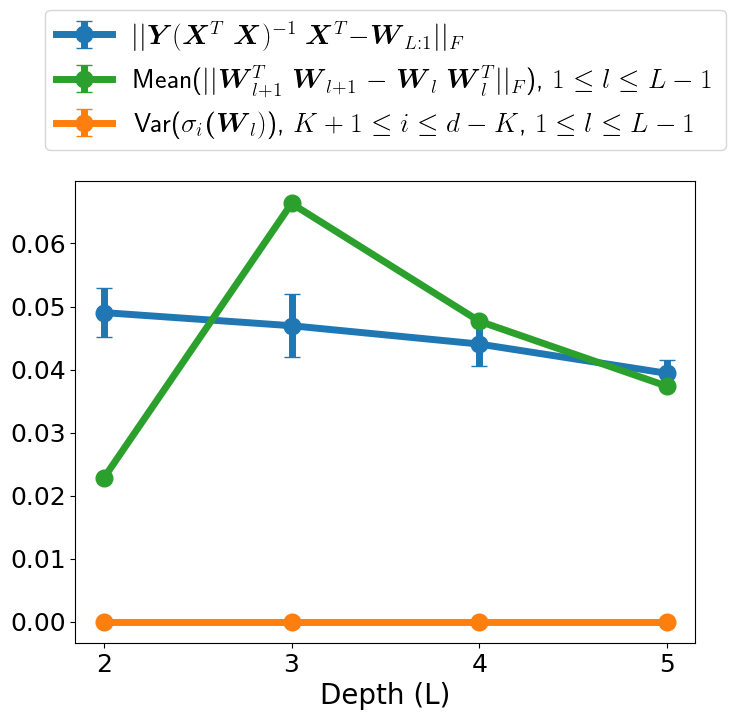

In [20]:
depth_list = np.array([1,2,3,4])+1

fig = plt.figure(figsize = (8,6))

plt.errorbar(depth_list, as1_d, yerr=as1_ds, capsize=6,
             color = 'tab:blue', linewidth = 5, marker="o", markersize=12,
             label = r"\unboldmath$||$\boldmath$Y$\unboldmath$($\boldmath$X$\unboldmath$^T$ \boldmath$X$\unboldmath$)^{-1}$ \boldmath$X$\unboldmath$^T - $\boldmath$W$\unboldmath$_{L:1}||_F$")
plt.errorbar(depth_list, as2_d, yerr=as2_ds, capsize=6,
             color = 'tab:green', linewidth = 5, marker="o",markersize=12,
             label = r"Mean(\unboldmath$||$\boldmath$W$\unboldmath$_{l+1}^T$ \boldmath$W$\unboldmath$_{l+1}$ \unboldmath$-$ \boldmath$W$\unboldmath$_{l}$ \boldmath$W$\unboldmath$_{l}^T||_F$), $1 \leq l \leq L-1$")
plt.errorbar(depth_list, as3_d, yerr=as3_ds, capsize=6,
             color='tab:orange', linewidth = 5, marker="o",markersize=12,
             label = r"Var(\unboldmath$\sigma_i$\boldmath$(W$\unboldmath$_{l})$), $K+1 \leq i \leq d-K$, $1 \leq l \leq L-1$")

matplotlib.rc('text', usetex=True)
plt.legend(fontsize=20, loc='upper center', bbox_to_anchor=(0.5,1.4), )
matplotlib.rc('text', usetex=False)


plt.xticks(depth_list, size=18)
plt.yticks(size=18)
plt.xlabel("Depth (L)",fontsize=20)

fig.savefig(f"figs/Assumption_all_depth.png", bbox_inches='tight')


In [22]:
with open("width.pkl", 'rb') as f: 
    as1_w_raw = pickle.load(f)['results']
    as1_w = get_mean(as1_w_raw)
    as1_ws = get_std(as1_w_raw)
with open("Assump2_width.pkl", 'rb') as f: 
    info = pickle.load(f)
    as2_w_raw = info['all']
    as2_w = get_mean(as2_w_raw)
    as2_ws = get_std(as2_w_raw)
with open("Assump3_width.pkl", 'rb') as f: 
    info = pickle.load(f)
    as3_w_raw = info['all']
    as3_w = get_mean(as3_w_raw)
    as3_ws = get_std(as3_w_raw)

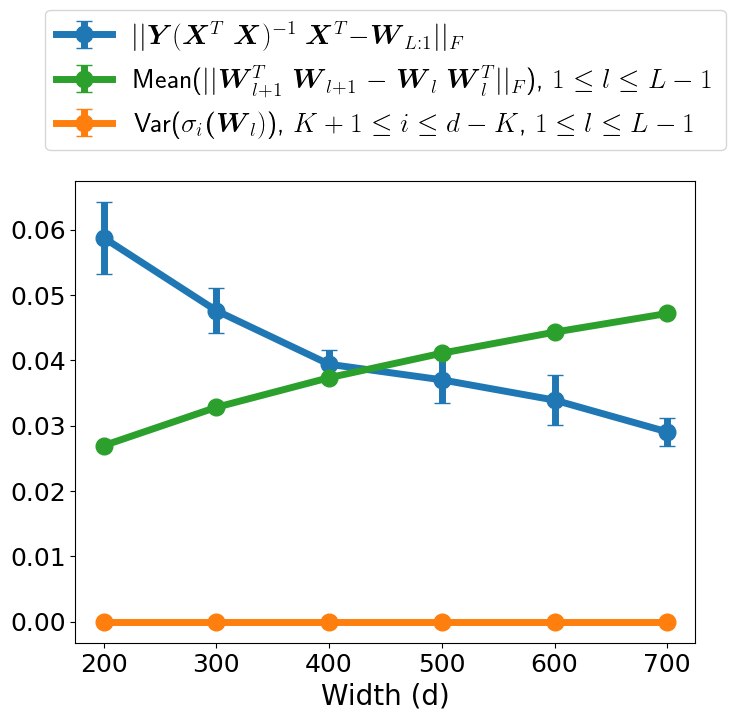

In [23]:
width_list = [200,300,400,500,600,700] 

fig = plt.figure(figsize = (8,6))

plt.errorbar(width_list, as1_w, yerr=as1_ws, capsize=6,
             color = 'tab:blue', linewidth = 5, marker="o", markersize=12,
             label = r"\unboldmath$||$\boldmath$Y$\unboldmath$($\boldmath$X$\unboldmath$^T$ \boldmath$X$\unboldmath$)^{-1}$ \boldmath$X$\unboldmath$^T - $\boldmath$W$\unboldmath$_{L:1}||_F$")
plt.errorbar(width_list, as2_w, yerr=as2_ws, capsize=6,
             color = 'tab:green', linewidth = 5, marker="o",markersize=12,
             label = r"Mean(\unboldmath$||$\boldmath$W$\unboldmath$_{l+1}^T$ \boldmath$W$\unboldmath$_{l+1}$ \unboldmath$-$ \boldmath$W$\unboldmath$_{l}$ \boldmath$W$\unboldmath$_{l}^T||_F$), $1 \leq l \leq L-1$")
plt.errorbar(width_list, as3_w, yerr=as3_ws, capsize=6,
             color='tab:orange', linewidth = 5, marker="o",markersize=12,
             label = r"Var(\unboldmath$\sigma_i$\boldmath$(W$\unboldmath$_{l})$), $K+1 \leq i \leq d-K$, $1 \leq l \leq L-1$")

matplotlib.rc('text', usetex=True)
plt.legend(fontsize=20, loc='upper center', bbox_to_anchor=(0.5,1.4), )
matplotlib.rc('text', usetex=False)


plt.xticks(width_list, size=18)
plt.yticks(size=18)
plt.xlabel("Width (d)",fontsize=20)

fig.savefig(f"figs/Assumption_all_width.png", bbox_inches='tight')
